<a href="https://colab.research.google.com/github/astrodeepnet/vae_mpoe/blob/main/VAE_HSC_interp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [164]:
from google.colab import drive
drive.mount('/content/drive/')

beta = 0.001

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


SB_10_v11_BASTI_baseFe_KU.fits	SB_2_v11_BASTI_baseFe_KU.fits  SB_6_v11_BASTI_baseFe_KU.fits
SB_11_v11_BASTI_baseFe_KU.fits	SB_3_v11_BASTI_baseFe_KU.fits  SB_7_v11_BASTI_baseFe_KU.fits
SB_12_v11_BASTI_baseFe_KU.fits	SB_4_v11_BASTI_baseFe_KU.fits  SB_8_v11_BASTI_baseFe_KU.fits
SB_1_v11_BASTI_baseFe_KU.fits	SB_5_v11_BASTI_baseFe_KU.fits  SB_9_v11_BASTI_baseFe_KU.fits
[   30.    40.    50.    60.    70.    80.    90.   100.   150.   200.
   250.   300.   350.   400.   450.   500.   600.   700.   800.   900.
  1000.  1250.  1500.  1750.  2000.  2250.  2500.  2750.  3000.  3250.
  3500.  3750.  4000.  4500.  5000.  5500.  6000.  6500.  7000.  7500.
  8000.  8500.  9000.  9500. 10000. 10500. 11000. 11500. 12000. 12500.
 13000. 13500. 14000.]


<ipython-input-165-e6369c51cfd3>:12: RuntimeWarning: divide by zero encountered in log10
  plt.pcolor(np.log10(hdulist[0].data))


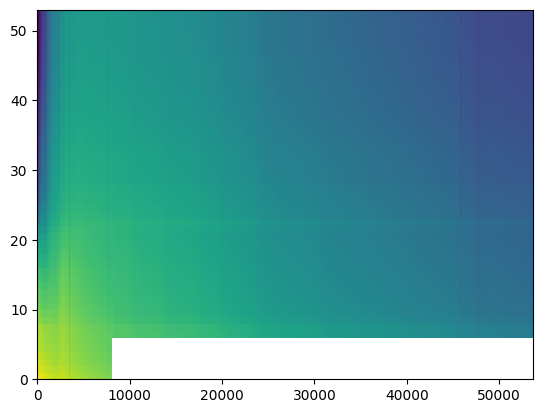

In [165]:
!ls '/content/drive/My Drive/EMILES'

from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

hdulist = fits.open('/content/drive/My Drive/EMILES/SB_9_v11_BASTI_baseFe_KU.fits')
np.log10(hdulist['ETS_PARA'].data['ZSTARS'] / 0.02)

print(hdulist['ETS_PARA'].data['AGE'])

plt.pcolor(np.log10(hdulist[0].data))
plt.show()



In [166]:
import requests

def fetch_filter_data(filters):
    filter_dict = {}

    for name, url in filters:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.text.splitlines()
            wavelength, transmission = [], []

            for line in data:
                parts = line.split()
                if len(parts) == 2:
                    try:
                        wavelength.append(float(parts[0]))
                        transmission.append(float(parts[1]))
                    except ValueError:
                        continue  # Skip lines that cannot be converted

            filter_dict[name] = {
                "wl": wavelength,
                "tr": transmission
            }
        else:
            print(f"Failed to fetch data for {name}")

    return filter_dict

filters = [['HSCg', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.g_filter'],
           ['HSCr', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.r_filter'],
           ['HSCi', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.i_filter'],
           ['HSCz', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.z_filter'],
           ['HSCY', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.Y_filter']]
filer_names = [name for name, _ in filters]

filter_data = fetch_filter_data(filters)


In [167]:
import os
import os
import glob
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import requests
from scipy.interpolate import interp1d

spec_points = 100
spec_range = (3900, 10200)

def bin_spectrum(spec, wl, spec_range, spec_points):
    min_wl, max_wl = spec_range
    bins = np.linspace(min_wl, max_wl, spec_points + 1)
    mean_values = []
    wl_values = []

    for i in range(len(bins) - 1):
        bin_mask = (wl >= bins[i]) & (wl < bins[i+1])
        bin_data = spec[bin_mask]
        mean_values.append(bin_data.mean() if bin_data.size > 0 else (bins[i] + bins[i+1]) / 2)
        wl_values.append(0.5*(bins[i] + bins[i+1]))
    return np.array(mean_values), np.array(wl_values)


def get_waves(hdr):
     waves = hdr['CRVAL1'] - (hdr['CRPIX1']-1.0)*hdr['CDELT1'] + ( np.arange(0., hdr['NAXIS1']) ) * hdr['CDELT1']
     ran = [waves[0], waves[-1]]
     return waves



def read_fits_files(directory):
    # Define the file pattern to match
    file_pattern = os.path.join(directory, "SB_?_v11_BASTI_baseFe_KU.fits")
    fits_files = glob.glob(file_pattern)

    all_spectra = []
    all_params = []

    for fits_file in fits_files:
        with fits.open(fits_file) as hdul:
            spectra = hdul[0].data  # Extracting spectral data
            params = hdul[1].data  # Extracting table data
            wl = get_waves(hdul[0].header)
            all_spectra.extend(spectra*wl**2)
            all_params.append(np.array([tuple(row) for row in params]))  # Ensure structured array consistency

    # Stack spectra along a new axis if necessary (e.g., assuming same dimensions)
    stacked_spectra = np.array(all_spectra)  # Convert list to numpy array

    # Convert list of structured arrays into a single structured array
    structured_params = np.concatenate(all_params) if all_params else None

    # Create an Astropy Table
    result_table = Table(rows=structured_params, names=params.names)

    wl = get_waves(hdul[0].header)
    return stacked_spectra, result_table, wl

# Example usage
#directory = "/content/drive/My Drive/EMILES/"  # Change to the directory containing your FITS files
#spectra, param_table, wl = read_fits_files(directory)


In [168]:
import numpy as np
import glob
from astropy.io import fits
from scipy import interpolate

def read_fits_files(pattern="SB_*_v11_BASTI_baseFe_KU.fits"):
    """Reads FITS files and constructs a 3D spectral array."""

    files = sorted(glob.glob(pattern))  # Get all relevant FITS files
    if not files:
        raise FileNotFoundError("No FITS files found matching pattern.")

    spectra_list = []
    ages = []
    mets = []

    for file in files:
        with fits.open(file) as hdul:
            primary_data = hdul[0].data  # Spectra
            params = hdul["ETS_PARA"].data  # Age & metallicity
            wl = get_waves(hdul[0].header)  # Wavelengths
            primary_data = np.array([fl*wl**2 for fl in primary_data])
            age = params["AGE"]  # Extract age
            met = params["ZSTARS"]  # Extract metallicity
            spectra_list.append(primary_data[age > 400])
            ages.append(np.log10(age)[age > 400])
            mets.append(np.log10(met/0.02)[age > 400])

    spectra_array = np.stack(spectra_list, axis=1)  # Convert list to 3D array

    # Convert age and metallicity into logarithmic scales divided by 0.2
    lages = np.array(ages)
    lmets = np.array(mets)

    return lages, lmets, spectra_array, wl

class SpectrumInterpolator:
    def __init__(self, lages, lmets, flx):
        """Initialize with log(age), log(metallicity), and flux array."""
        self.lages = np.unique(lages)  # Ensure uniqueness
        self.mets = np.unique(lmets)
        self.flx = flx
        print(self.lages, self.mets)
        # Create interpolators for each wavelength slice
        self.interpolators = [
            interpolate.RectBivariateSpline(self.lages, self.mets, flx[:, :, i])
            for i in range(flx.shape[2])
        ]

    def evaluate(self, age, metallicity):
        """Evaluate spectrum at arbitrary log(age) and log(metallicity)."""
        log_age = np.log10(age)
        log_met = metallicity

        return np.array([interp(log_age, log_met)[0, 0] for interp in self.interpolators])

# Usage Example
lages, lmets, flx, wl = read_fits_files('/content/drive/My Drive/EMILES/SB_*_v11_BASTI_baseFe_KU.fits')
spectrum_interp = SpectrumInterpolator(lages, lmets, flx)

# Evaluate spectrum at specific age and metallicity
age_sample = 1100  # Example age (5 Gyr)
met_sample = -0.50  # Example metallicity

def calc_spec(wl, age = 1000, met = 0.00, z=0.0):
    spec = spectrum_interp.evaluate(age, met)
    return (spec, wl*(1 + z))


'''
def calc_spec(spectra, param_table, wl, age = 1000, met = 0.02, z=0.0):
    da = np.abs(param_table['AGE'] - age)
    dm = np.abs(param_table['ZSTARS']/met - 1)
    idx = np.where((da == np.min(da)) & (dm == np.min(dm)))[0]
    spec = spectra[idx][0]
    return (spec, wl*(1 + z))
'''

[2.6532125 2.69897   2.7781513 2.845098  2.90309   2.9542425 3.
 3.09691   3.1760912 3.2430382 3.30103   3.3521826 3.39794   3.4393327
 3.4771214 3.5118833 3.544068  3.5740314 3.60206   3.6532125 3.69897
 3.7403626 3.7781513 3.8129134 3.845098  3.8750613 3.90309   3.929419
 3.9542425 3.9777236 4.        4.021189  4.041393  4.060698  4.079181
 4.09691   4.1139436 4.130334  4.146128 ] [-2.27       -1.79       -1.49       -1.26       -0.96       -0.66
 -0.35       -0.25        0.06000002  0.15        0.26        0.39999998]


"\ndef calc_spec(spectra, param_table, wl, age = 1000, met = 0.02, z=0.0):\n    da = np.abs(param_table['AGE'] - age)\n    dm = np.abs(param_table['ZSTARS']/met - 1)\n    idx = np.where((da == np.min(da)) & (dm == np.min(dm)))[0]\n    spec = spectra[idx][0]\n    return (spec, wl*(1 + z))\n"

In [169]:
def download_filter_curve(url):
    """Download and parse the filter transmission curve from a given URL."""
    response = requests.get(url)
    response.raise_for_status()
    data = np.loadtxt(response.iter_lines())
    return data[:, 0], data[:, 1]  # wavelengths, transmissions

def calculate_flux_and_mag(spectra_list, wavelengths_list, filters):
    """Calculate the flux and AB magnitude for multiple spectra and filters."""
    all_results = []
    all_speclr = []
    all_wllr = []

    for spectra, wavelengths in zip(spectra_list, wavelengths_list):
        results = []
        speclr, wllr = bin_spectrum(spectra, wavelengths, spec_range, spec_points)
        for filter_name, filter_url in filters:
            #filter_wavelengths, transmissions = download_filter_curve(filter_url)
            fd = filter_data[filter_name]
            filter_wavelengths, transmissions = fd['wl'], fd['tr']
            # Interpolate spectra onto the filter transmission wavelengths
            interp_flux = interp1d(wavelengths, spectra, kind='linear', fill_value=0, bounds_error=False)
            flux_interp = interp_flux(filter_wavelengths)
            filter_wavelengths = np.array(filter_wavelengths)
            # Calculate total flux (assuming simple integration)
            total_flux = np.trapz(flux_interp * transmissions, filter_wavelengths)
            total_flux /= np.trapz(transmissions, filter_wavelengths)
            #total_flux /= np.nanmax(total_flux)

            # Calculate AB magnitude
            if total_flux > 0:
                ab_magnitude = -2.5 * np.log10(total_flux) - 48.6  # AB mag formula
            else:
                ab_magnitude = np.inf  # Undefined magnitude for zero flux

            results.append([filter_name, total_flux, ab_magnitude])

        all_results.append(results)
        all_speclr.append(speclr)
        all_wllr.append(wllr)

    return all_results, [all_speclr, all_wllr]


filters = [['HSCg', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.g_filter'],
           ['HSCr', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.r_filter'],
           ['HSCi', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.i_filter'],
           ['HSCz', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.z_filter'],
           ['HSCY', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.Y_filter']]

spectra_list = []
wavelengths_list = []

num_samples = 2000  # Adjust as needed
z_vals = np.random.uniform(0, 1.3, num_samples)
age_vals = np.random.uniform(1000, 15000, num_samples)
metdex_vals = np.random.uniform(-0.9, 0.1, num_samples)

spectra_list = []
wavelengths_list = []
param_list = []

for z, age, metdex in zip(z_vals, age_vals, metdex_vals):
    gen = calc_spec(wl, age=age, met=metdex, z=z)
    spectra_list.append(gen[0])
    wavelengths_list.append(gen[1])
    param_list.append([z, age, metdex])  # Store the corresponding parameters


print(len(spectra_list))
print(len(wavelengths_list))
mags, lr = calculate_flux_and_mag(spectra_list, wavelengths_list, filters)

output_array = [[[entry[1] for entry in mag_entry], params, speclr] for mag_entry, params, speclr in zip(mags, param_list, lr[0])]

2000
2000


<ipython-input-169-f26792f7c060>:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_flux = np.trapz(flux_interp * transmissions, filter_wavelengths)
<ipython-input-169-f26792f7c060>:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_flux /= np.trapz(transmissions, filter_wavelengths)


In [170]:

output_array = [[[float(val) for val in flux_list], [float(params[0]), float(params[1]), params[2]], lr] for flux_list, params, lr in output_array]

print(len(output_array))

N_smpl = 80  # Number of realizations per entry

# Create new array with perturbations
dataset_rnd = []

for flux_list, params, lr in output_array:
    for _ in range(N_smpl):
        perturbed_flux = [val + 0.1 * np.random.uniform(0, 1) * val for val in flux_list]  # Add perturbation
        dataset_rnd.append([perturbed_flux, params, lr])  # Duplicate params as required


integrals = np.array([entry[0] / np.max(entry[0]) for entry in dataset_rnd])  # 2D array of flux values
params = np.array([entry[1] for entry in dataset_rnd])  # 2D array of corresponding parameters
params[:, 1] /= 1e4
spectra = np.array([entry[2] / np.max(entry[2]) for entry in dataset_rnd])  # 2D array of corresponding parameters
#spectra = 1e5 * np.array(spectra)


2000


In [171]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import ops
from keras import layers

import numpy as np
import matplotlib.pyplot as plt



class Sampling(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


def build_dense_encoder_sed_branch(input_shape):
    dense_input = keras.Input(shape=input_shape)
#    x = layers.Dense(64, activation='relu')(dense_input)
#    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(dense_input)
    x = layers.Dense(16, activation='relu')(x)
    return keras.Model(dense_input, x, name='dense_encoder_branch')

def build_dense_decoder_sed(latent_dim, output_dim):
    latent_inputs = keras.Input(shape=(latent_dim,), name=f'z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
#    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(output_dim, activation='sigmoid')(x)
    return keras.Model(latent_inputs, outputs, name='dense_decoder')

def build_encoder_sp_branch(input_shape):
    cnn_input = keras.Input(shape=input_shape)
    #x = layers.Conv1D(32, 3, activation='relu', strides=2, padding='same')(cnn_input)
    #x = layers.Conv1D(64, 3, activation='relu', strides=2, padding='same')(x)
    #x = layers.Conv1D(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(cnn_input)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    return keras.Model(cnn_input, x, name='cnn_encoder')

def build_dense_decoder_sp(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    #x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    #x = layers.Dense(256, activation='relu')(x)
    #x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(output_dim[0])(x)
    #outputs = layers.Reshape(output_dim)(x)

    decoder = keras.Model(latent_inputs, outputs, name='dense_decoder')
    return decoder


def corner_plot(r, max_params):
    axs = tuple(range(min(max_params, r[0].shape[1])))  # Ensure indices do not exceed max dimensions
    fig, axes = plt.subplots(len(axs), len(axs), figsize=(10, 10))

    for i, ax_i in enumerate(axs):
        for j, ax_j in enumerate(axs):
            ax = axes[i, j]

            if i == j:
                # Diagonal: 1D histogram
                ax.hist(r[0][:, ax_i], bins=100, color='steelblue', alpha=0.7)
            elif i > j:
                # Lower triangle: 2D histogram
                ax.hist2d(r[0][:, ax_j], r[0][:, ax_i], bins=100, cmap='Blues')
            else:
                # Upper triangle: empty space
                ax.set_visible(False)

            # Remove ticks for clarity
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()

In [172]:
class SpectraVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_encoder_sp_branch((input_dim,1))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])

        self.encoder = keras.Model(self.encoder_branch.inputs, [self.z_mean, self.z_log_var, self.z], name='cnn_encoder')

        self.decoder = build_dense_decoder_sp(latent_dim,(input_dim,1))
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        return self.apply(data)[3]



    def train_step(self, data):
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data)
            reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data - reconstruction)/data))
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        (z_mean, z_log_var, z, reconstruction) = self.apply(data)
        reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data - reconstruction)/data))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

[ 0.59941149  0.45778313 -0.84191942]


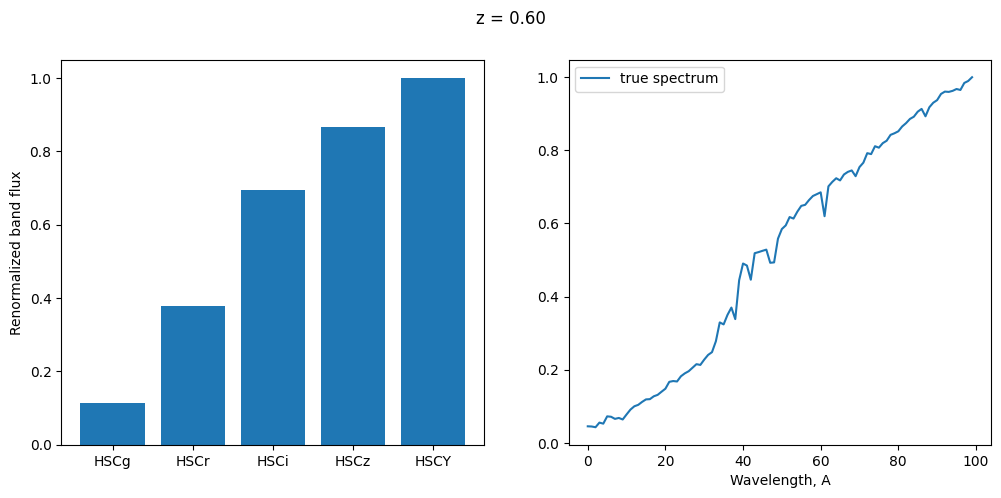

[ 0.59941149  0.45778313 -0.84191942]


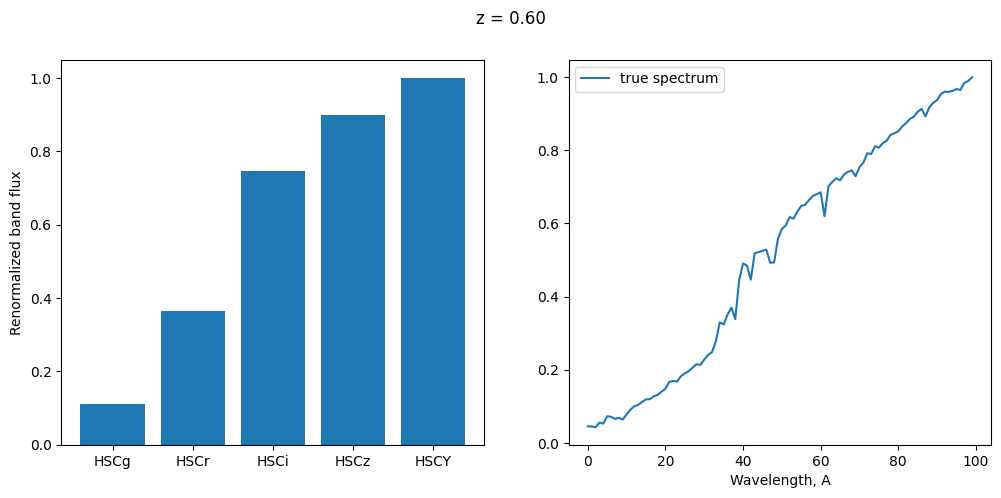

[ 0.59941149  0.45778313 -0.84191942]


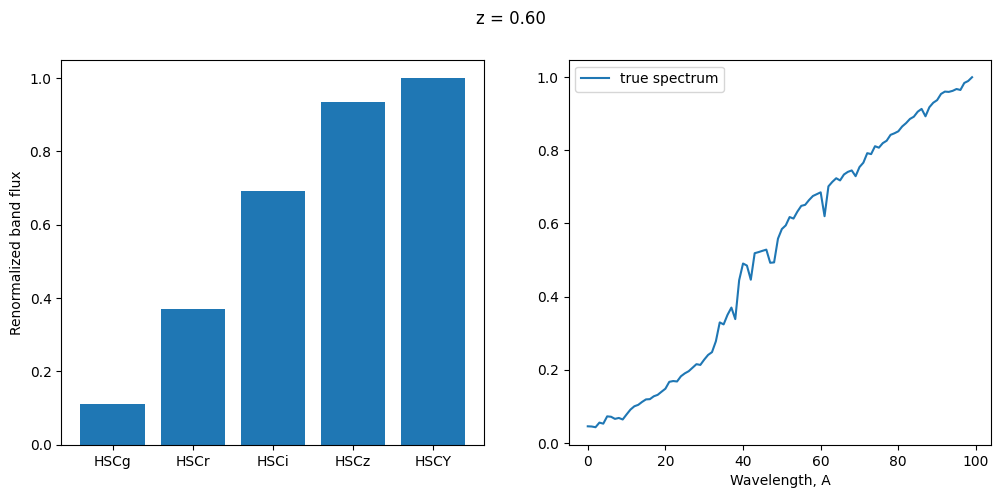

[ 0.59941149  0.45778313 -0.84191942]


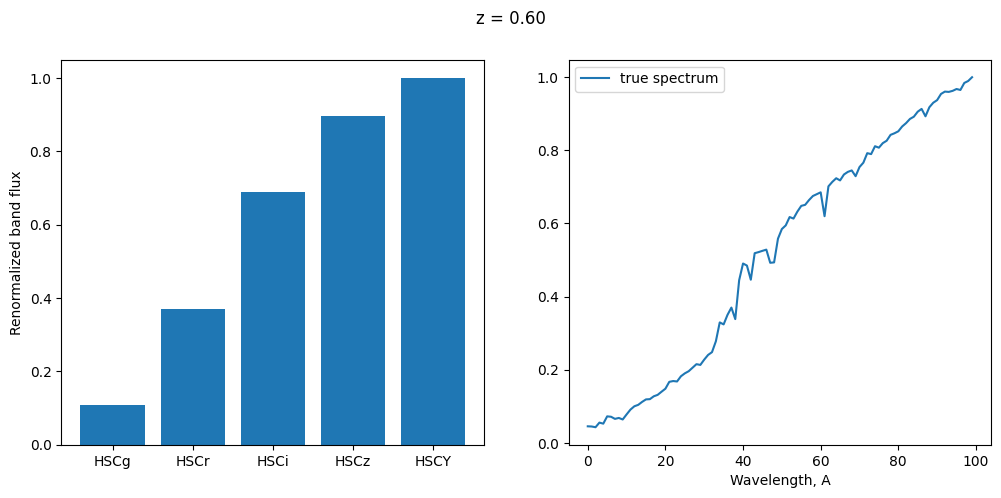

[ 0.59941149  0.45778313 -0.84191942]


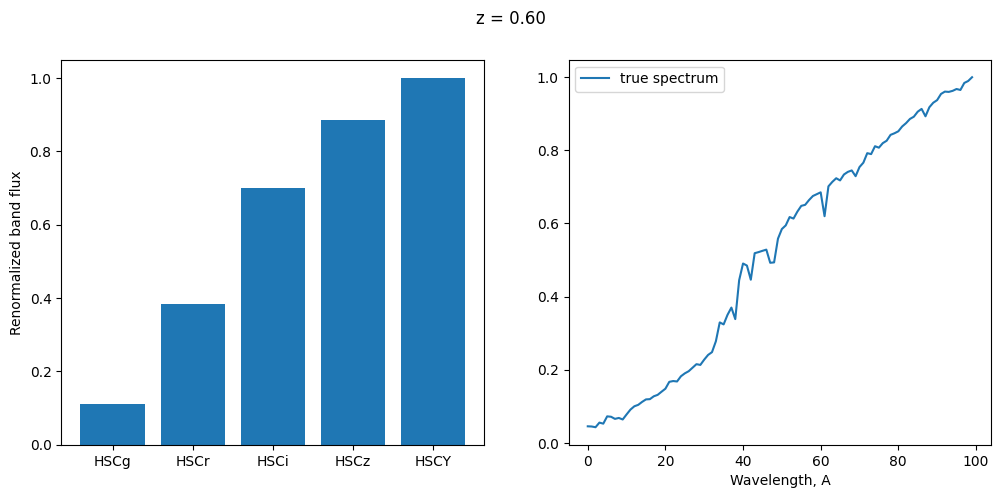

[ 0.59941149  0.45778313 -0.84191942]


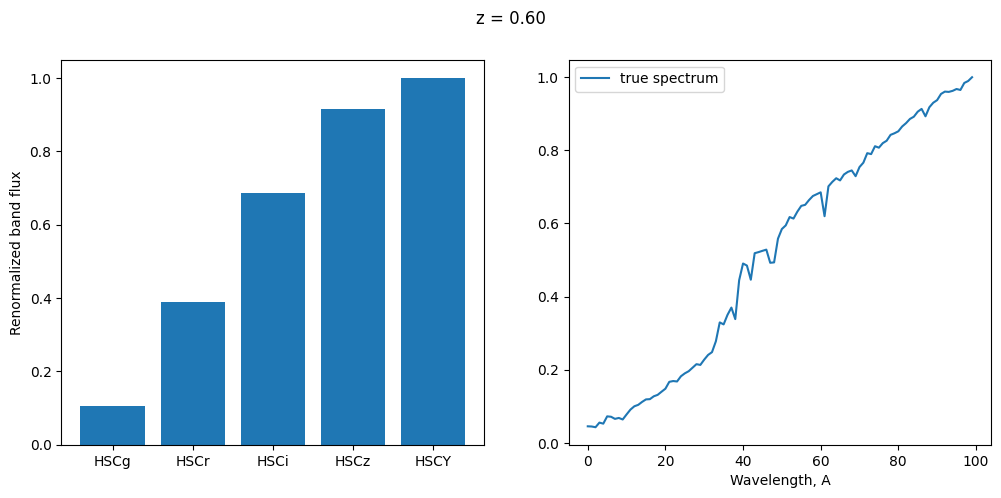

[ 0.59941149  0.45778313 -0.84191942]


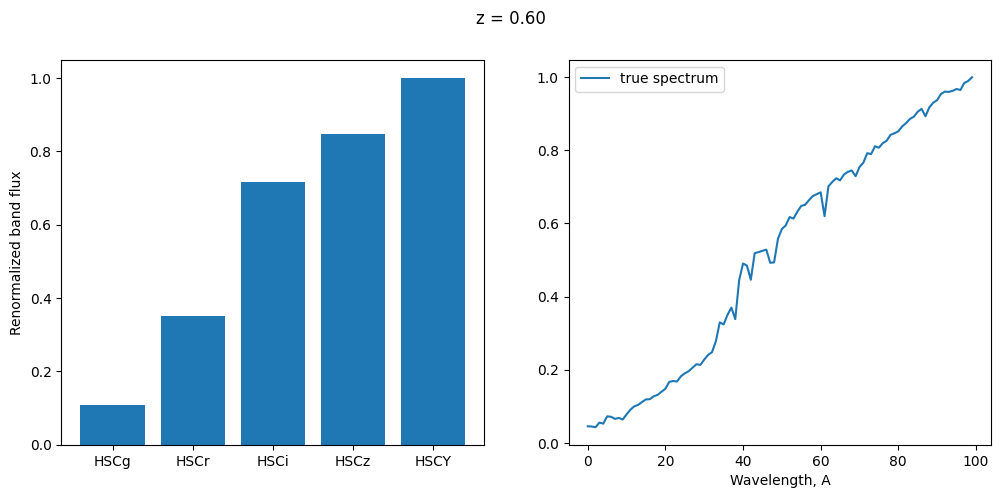

[ 0.59941149  0.45778313 -0.84191942]


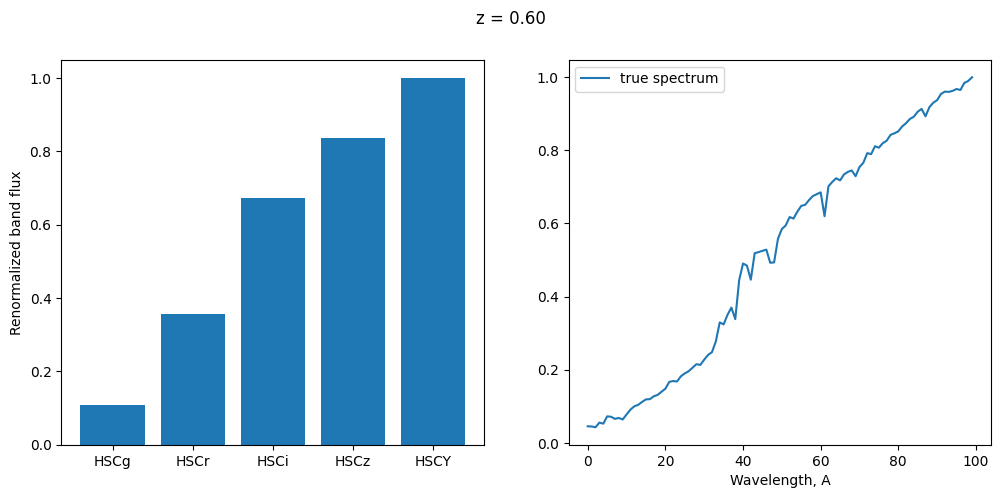

[ 0.59941149  0.45778313 -0.84191942]


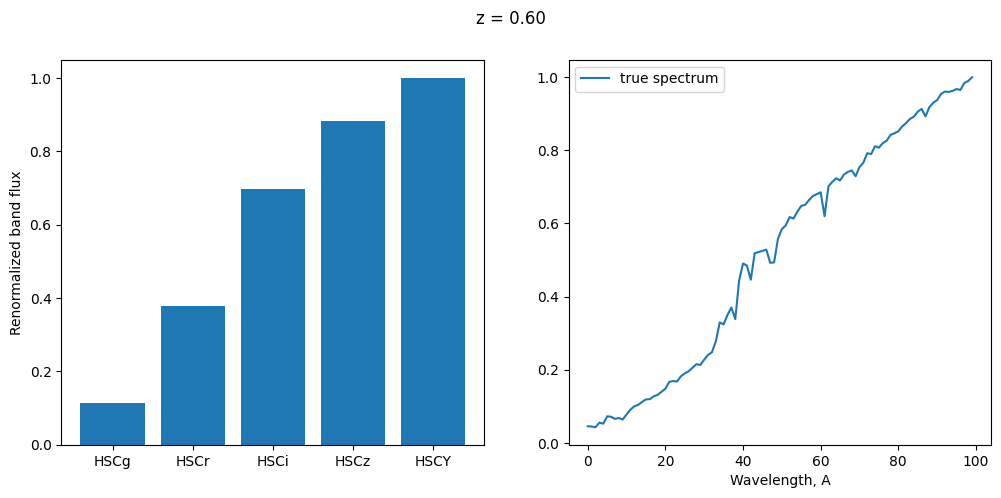

[ 0.59941149  0.45778313 -0.84191942]


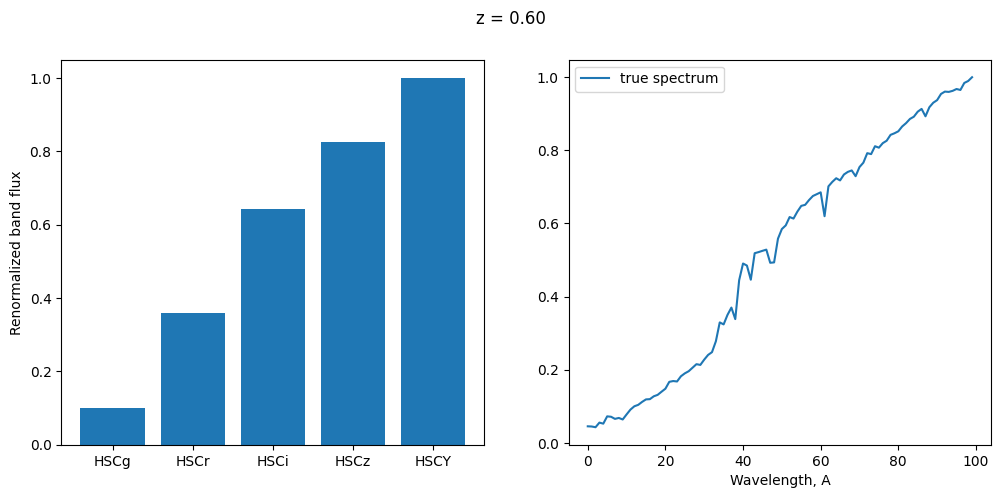

In [173]:
ii=1000
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    axs[1].set_xlabel('Wavelength, A')
    axs[0].bar(filer_names, integrals[ii])
    axs[0].set_ylabel('Renormalized band flux')
    print(params[ii])
    fig.suptitle('z = %.2f' % (params[ii, 0]))
    plt.legend()
    plt.show()

In [174]:
spvae = SpectraVAE(100, 16, beta=beta)
spvae.compile(optimizer=keras.optimizers.Adam())
hsp=spvae.fit(spectra, epochs=50, batch_size=128, validation_split=0.2)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_165']
Received: inputs=Tensor(shape=(128, 100))
  warnings.warn(msg)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - kl_loss: 16.2977 - loss: 0.0709 - reconstruction_loss: 0.0546 - val_kl_loss: 10.5549 - val_loss: 0.0585 - val_reconstruction_loss: 0.0479
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - kl_loss: 10.3263 - loss: 0.0250 - reconstruction_loss: 0.0147 - val_kl_loss: 8.8684 - val_loss: 0.0279 - val_reconstruction_loss: 0.0191
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - kl_loss: 7.8544 - loss: 0.0172 - reconstruction_loss: 0.0093 - val_kl_loss: 7.7304 - val_loss: 0.0221 - val_reconstruction_loss: 0.0144
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - kl_loss: 6.5431 - loss: 0.0145 - reconstruction_loss: 0.0080 - val_kl_loss: 7.1524 - val_loss: 0.0196 - val_reconstruction_loss: 0.0124
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - kl_loss: 6.0799 - loss: 0.0133 - reconstruction_loss: 0.0072 - val_kl_loss: 6.5647 - val_loss: 0.0200 - val_reconstruction_loss: 0.0134
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_165']
Received: inputs=Tensor(shape=(1, 100))
  warnings.warn(msg)


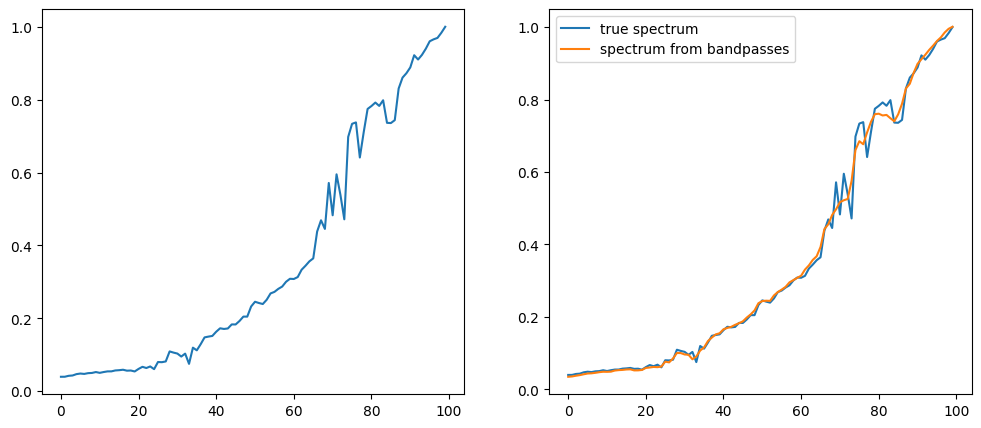

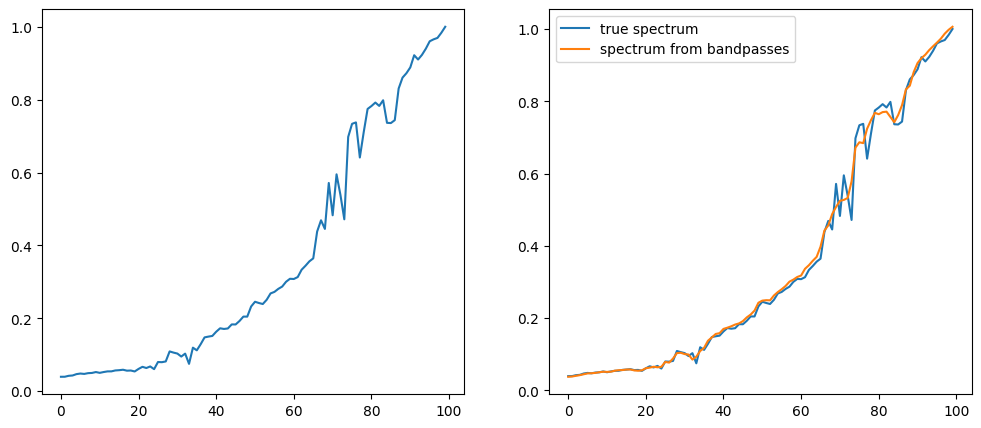

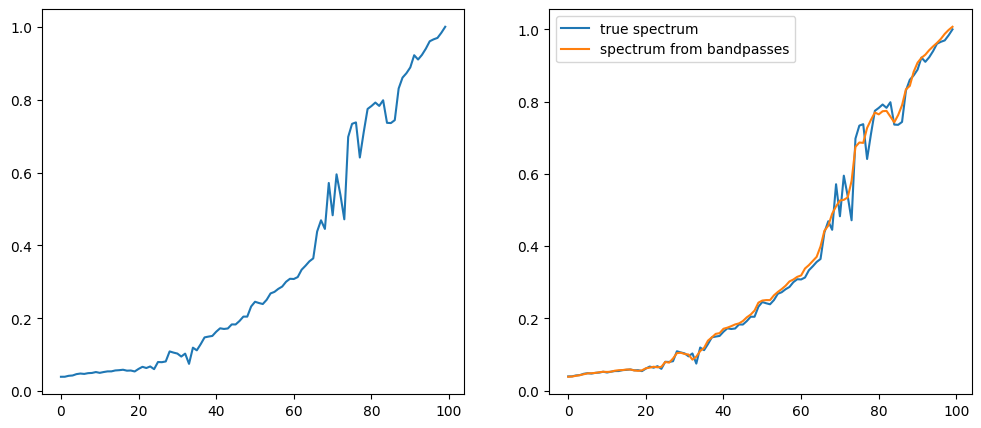

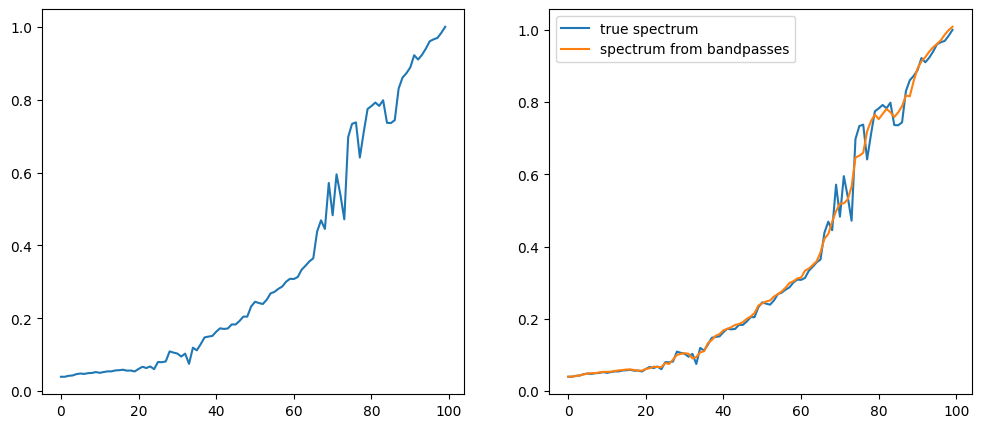

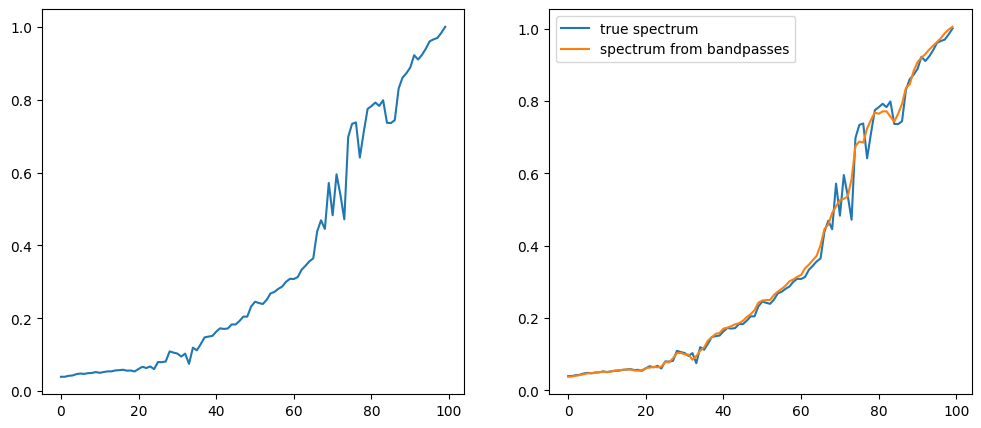

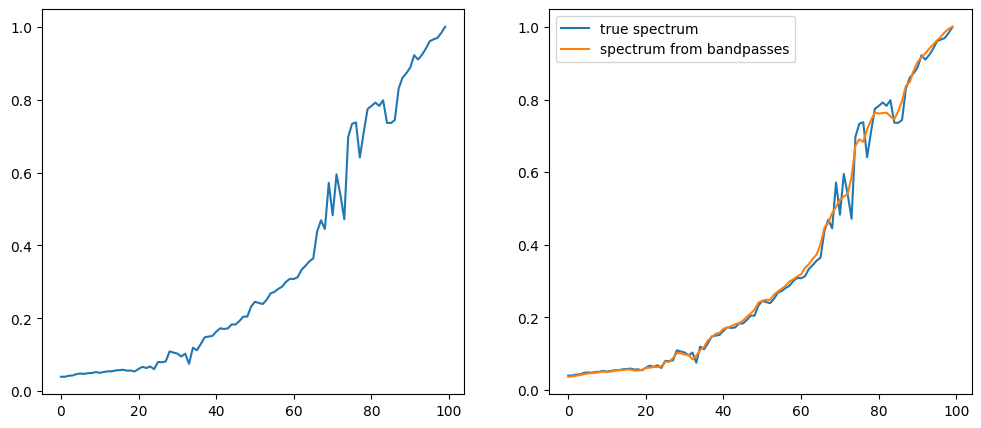

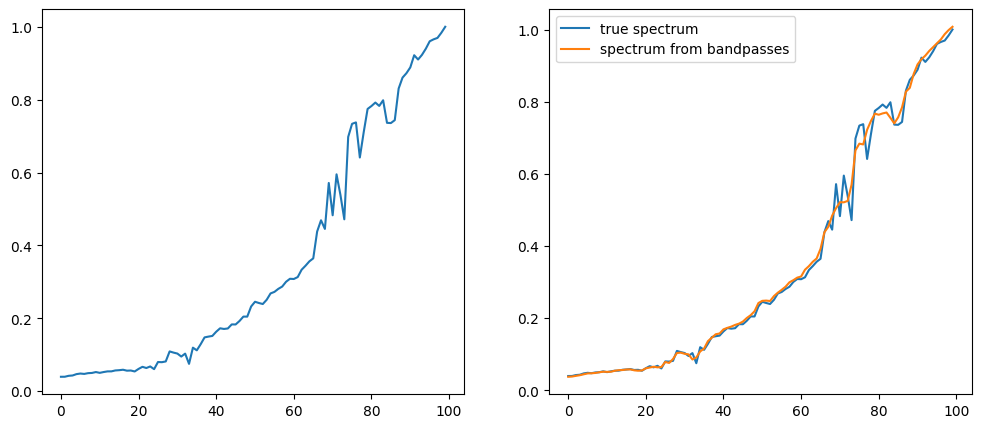

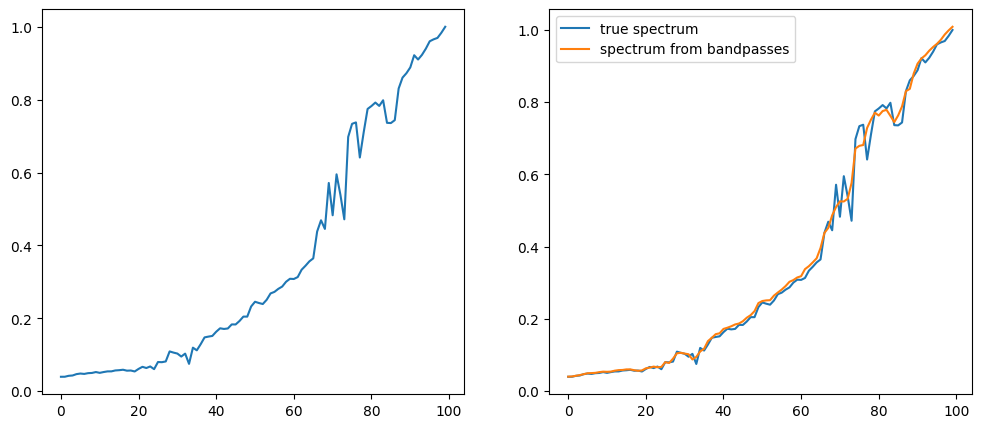

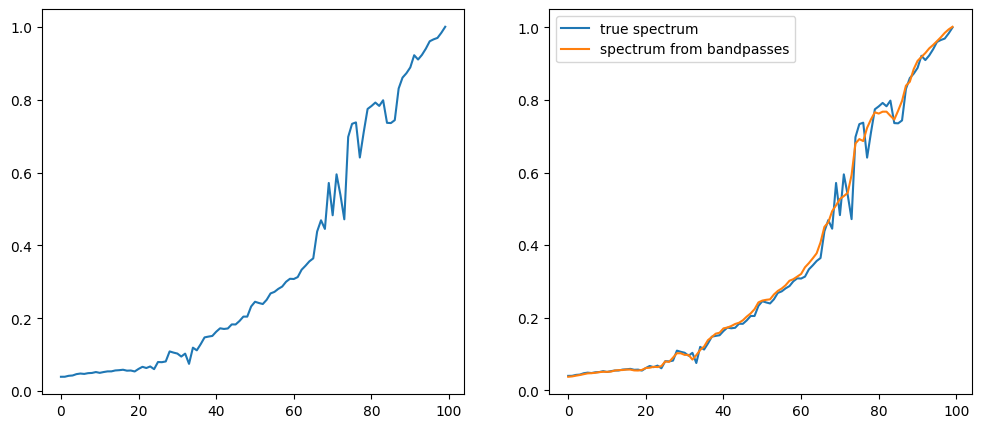

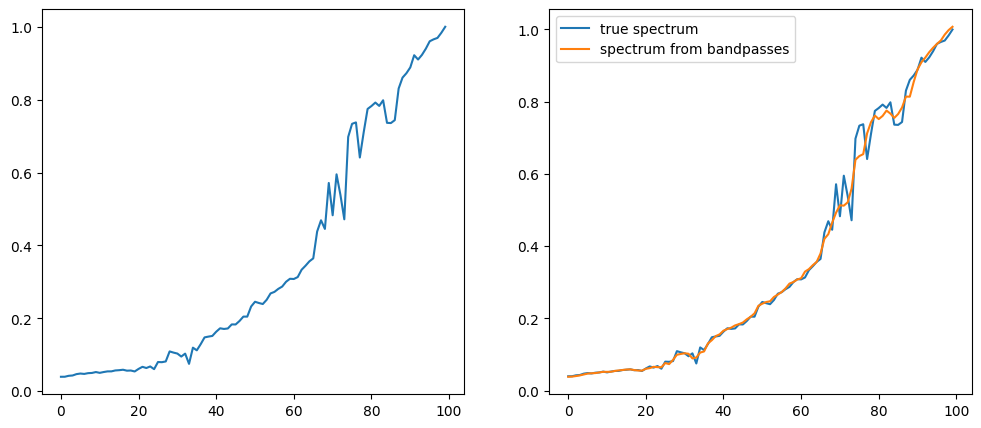

In [175]:
ii=1126
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    s = spvae(np.reshape(spectra[ii], (1,100)))
    s = np.reshape(s[0].numpy(),(100,))
    axs[1].plot(s, label="spectrum from bandpasses")
    axs[0].plot(range(len(spectra[ii])), spectra[ii])
    plt.legend()
    plt.show()

In [176]:
class BandPassVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_dense_encoder_sed_branch((input_dim,))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])

        self.encoder = keras.Model(self.encoder_branch.inputs, [self.z_mean, self.z_log_var, self.z], name='dense_encoder')

        self.decoder = spvae.decoder
        self.decoder.trainable = False  # Prevent training of the decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        data_in = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        (data_in, data_out) = data[0]
        return self.apply(data_in)[3]

    def train_step(self, data):
        (data_in, data_out) = data[0]
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
            reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data_out - reconstruction)/data_out))
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        print(data)
        (data_in, data_out) = data[0]
        (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
        reconstruction_loss = ops.mean(
                #keras.losses.mean_squared_error(data, reconstruction),
                tf.keras.backend.mean(tf.keras.backend.square((data_out - reconstruction)/data_out))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        data_in  = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return reconstruction

In [177]:
bpvae = BandPassVAE(5,16, beta=beta)
bpvae.compile(optimizer=keras.optimizers.Adam())
h=bpvae.fit((integrals, spectra), epochs=50, batch_size=128, validation_split=0.2)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_180']
Received: inputs=Tensor(shape=(128, 5))
  warnings.warn(msg)


 992/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 7.2399 - loss: 0.2067 - reconstruction_loss: 0.1994((<tf.Tensor 'data:0' shape=(128, 5) dtype=float32>, <tf.Tensor 'data_1:0' shape=(128, 100) dtype=float32>),)
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - kl_loss: 7.2662 - loss: 0.2054 - reconstruction_loss: 0.1981 - val_kl_loss: 5.2994 - val_loss: 0.0627 - val_reconstruction_loss: 0.0574
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - kl_loss: 9.8249 - loss: 0.0505 - reconstruction_loss: 0.0407 - val_kl_loss: 5.5446 - val_loss: 0.0614 - val_reconstruction_loss: 0.0558
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - kl_loss: 7.1227 - loss: 0.0361 - reconstruction_loss: 0.0290 - val_kl_loss: 5.9520 - val_loss: 0.0627 - val_reconstruction_loss: 0.0567
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - kl_loss: 6.3402 - loss: 0.0337 - reconstruction_loss: 0.0273 - val_kl_loss: 5.7817 - val_loss: 0.0609 - val_reconstruction_loss: 0.0551
Epoch 5/50
1000/1000 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_180']
Received: inputs=Tensor(shape=(1, 5))
  warnings.warn(msg)


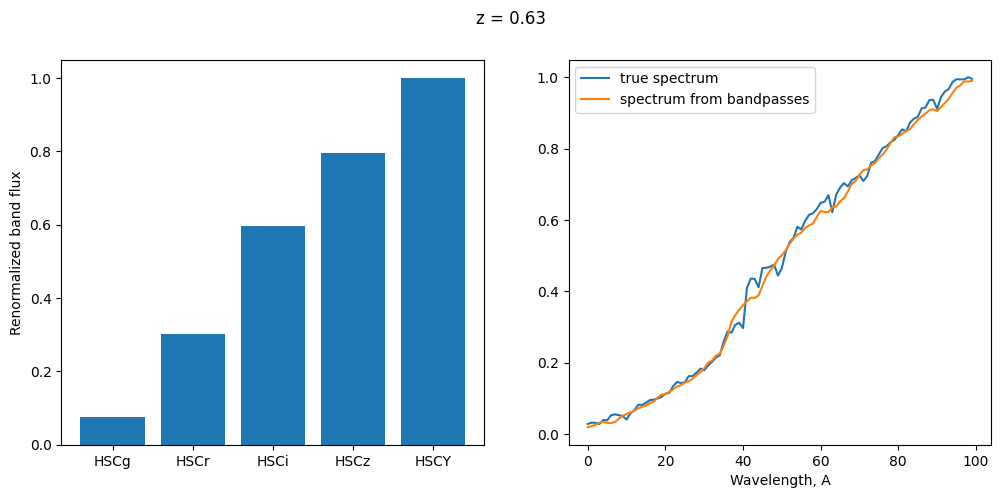

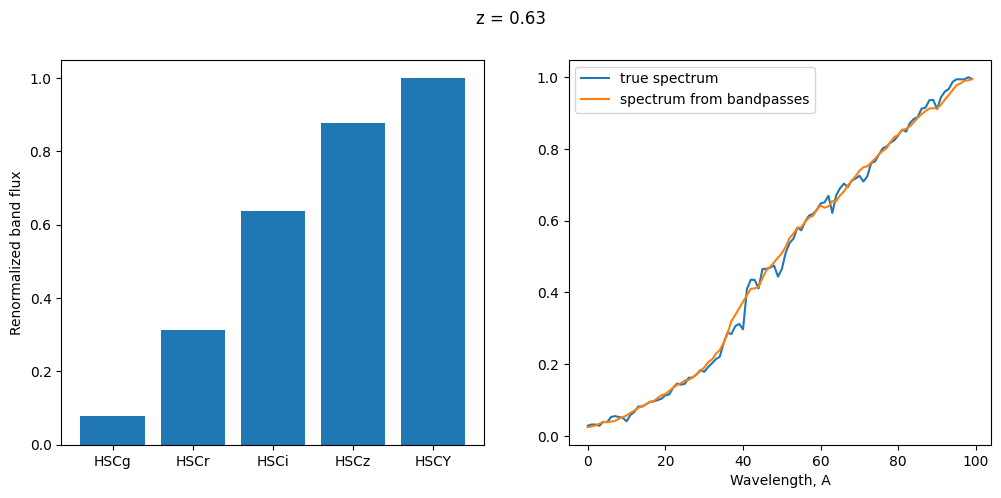

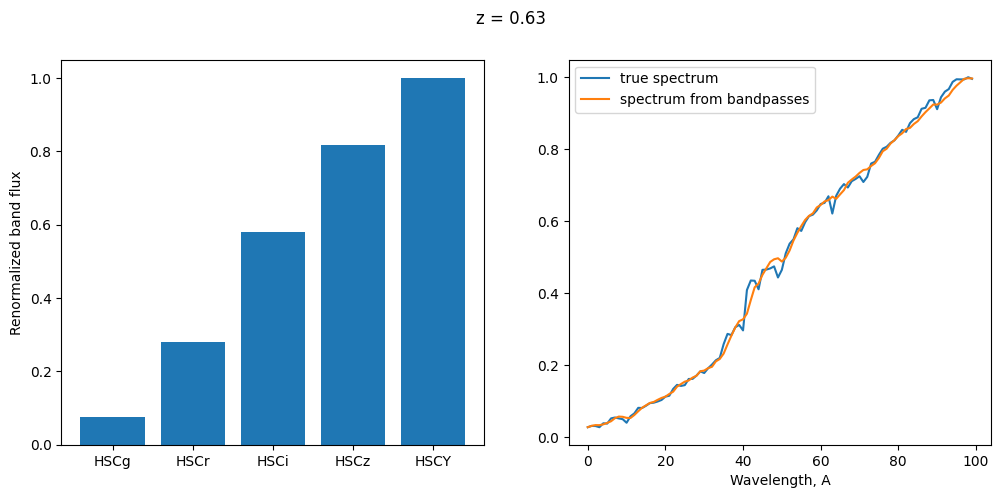

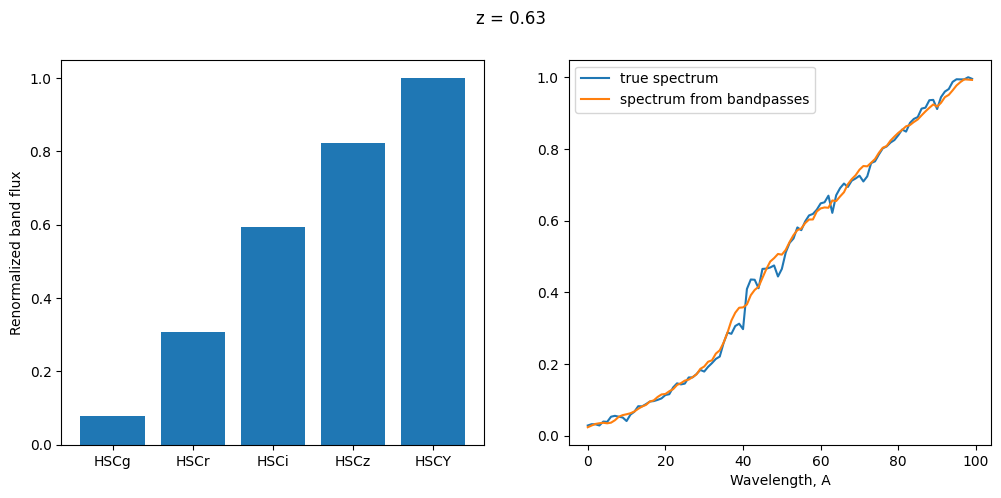

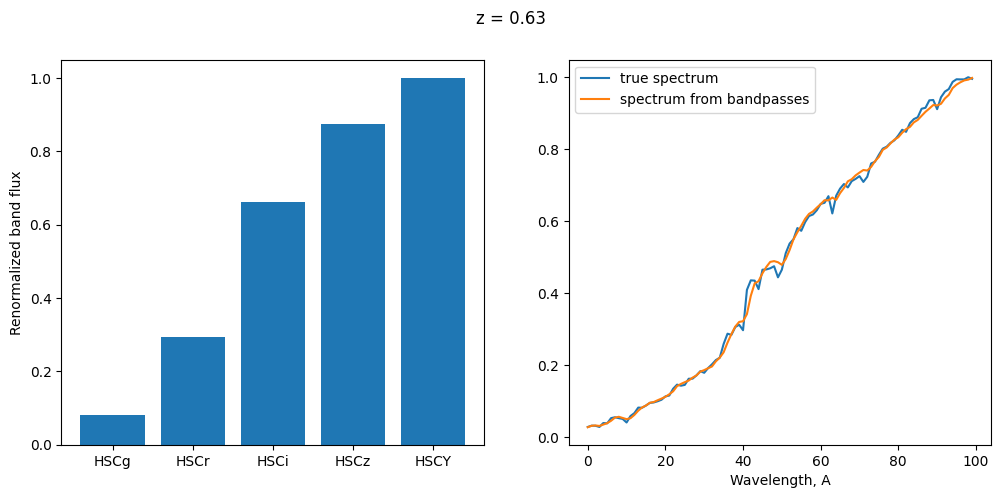

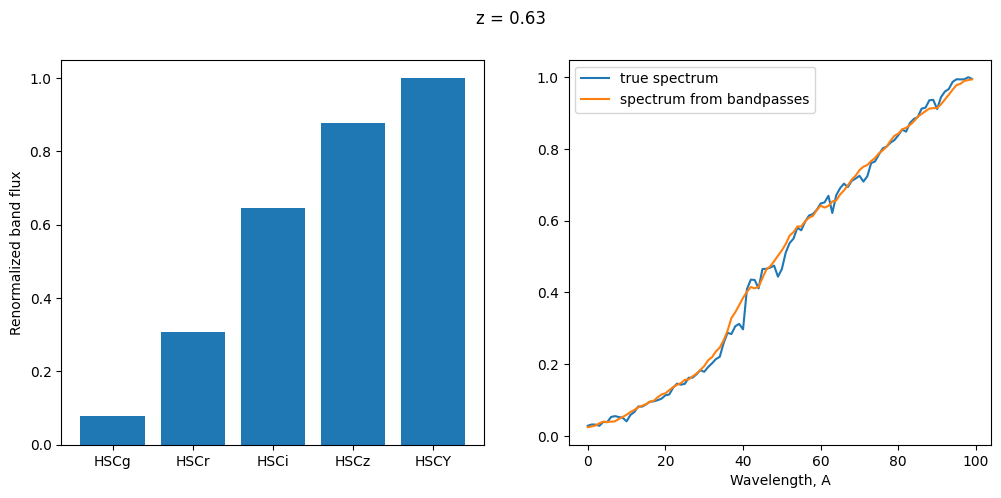

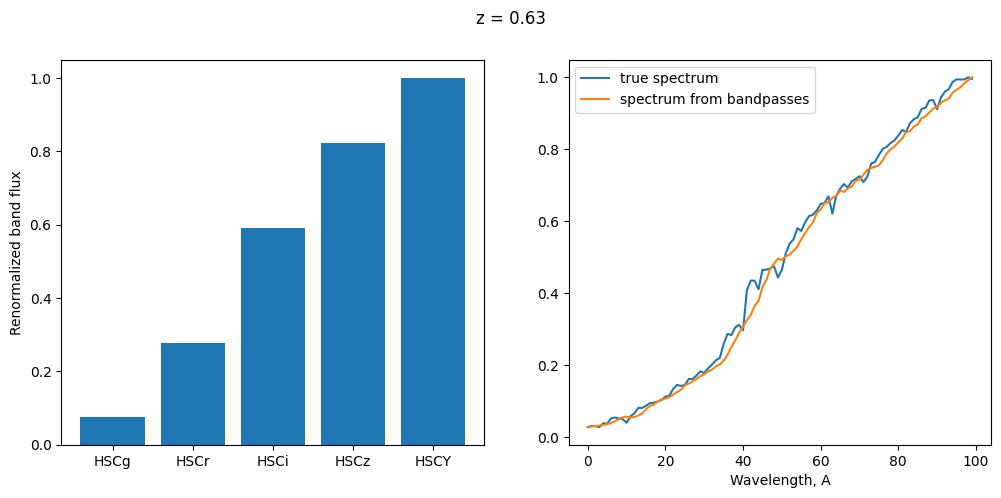

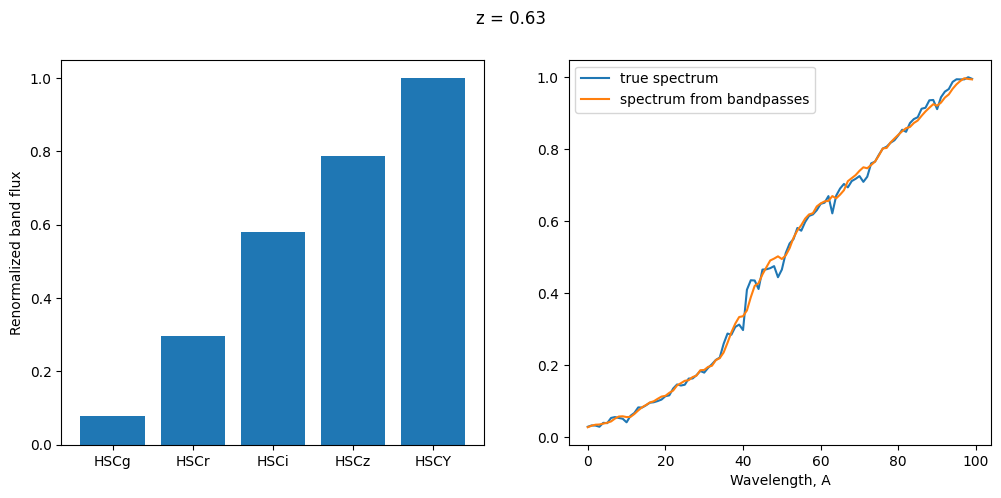

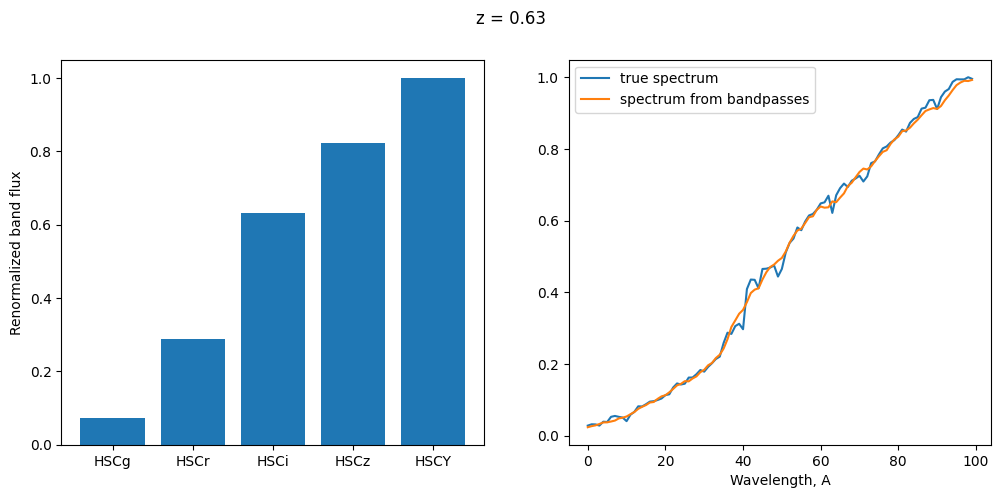

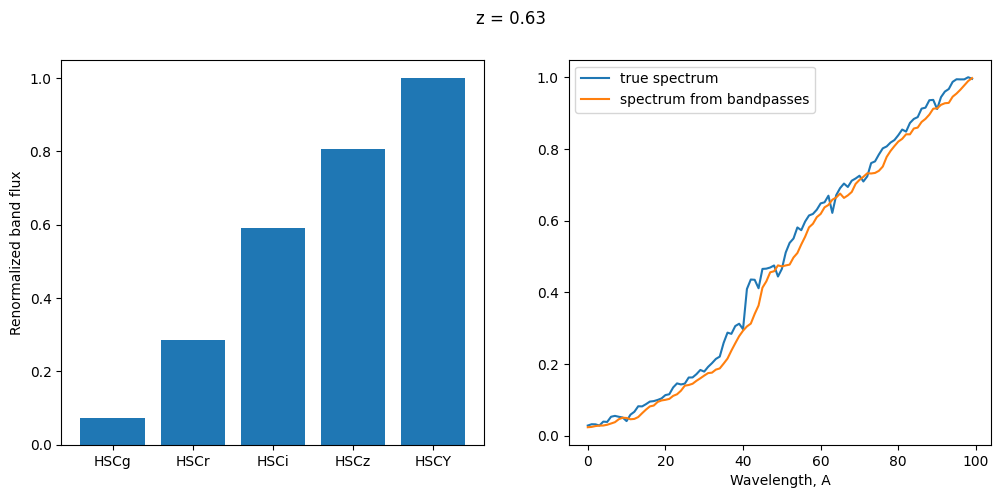

In [178]:
ii=10126
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    s = bpvae(np.reshape(integrals[ii], (1,5)))
    s = np.reshape(s[0].numpy(),(100,))
    axs[1].plot(s, label="spectrum from bandpasses")
    axs[1].set_xlabel('Wavelength, A')
    axs[0].bar(filer_names, integrals[ii])
    axs[0].set_ylabel('Renormalized band flux')
    fig.suptitle('z = %.2f' % (params[ii, 0]))
    plt.legend()
    plt.show()

In [179]:
def build_dense_decoder_param(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(output_dim[0])(x)

    decoder = keras.Model(latent_inputs, outputs, name='dense_decoder')
    return decoder


class ParamVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_dense_encoder_sed_branch((input_dim,))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])
        self.wei = np.array([10, 1, 1])
        self.wei = self.wei / np.sum(self.wei)
        self.encoder = bpvae.encoder
        self.encoder.trainable = False  # Prevent training of the decoder

        self.decoder = build_dense_decoder_param(latent_dim,(3,1))
        self.decoder.trainable = True  # Prevent training of the decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        data_in = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        (data_in, data_out) = data[0]
        return self.apply(data_in)[3]

    def train_step(self, data):
        (data_in, data_out) = data[0]
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
            reconstruction_loss = ops.mean(
                tf.keras.backend.square(data_out*self.wei - reconstruction*self.wei)
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        print(data)
        (data_in, data_out) = data[0]
        (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
        reconstruction_loss = ops.mean(
                #keras.losses.mean_squared_error(data, reconstruction),
                tf.keras.backend.mean(tf.keras.backend.square(data_out - reconstruction))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        data_in  = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return reconstruction

In [180]:
print(params[0])

parvae = ParamVAE(3,16, beta=beta)
parvae.compile(optimizer=keras.optimizers.Adam())
h=parvae.fit((integrals, params), epochs=50, batch_size=128, validation_split=0.2)

[ 1.04467351  0.94363686 -0.3497278 ]
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['dense_112/kernel', 'dense_112/bias', 'dense_113/kernel', 'dense_113/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


 984/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.3817 - loss: 0.0101 - reconstruction_loss: 0.0047((<tf.Tensor 'data:0' shape=(128, 5) dtype=float32>, <tf.Tensor 'data_1:0' shape=(128, 3) dtype=float32>),)
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - kl_loss: 5.3814 - loss: 0.0101 - reconstruction_loss: 0.0047 - val_kl_loss: 6.7342 - val_loss: 0.0677 - val_reconstruction_loss: 0.0609
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 5.3815 - loss: 0.0068 - reconstruction_loss: 0.0014 - val_kl_loss: 6.7342 - val_loss: 0.0684 - val_reconstruction_loss: 0.0617
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 5.3816 - loss: 0.0066 - reconstruction_loss: 0.0012 - val_kl_loss: 6.7342 - val_loss: 0.0454 - val_reconstruction_loss: 0.0387
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 5.3816 - loss: 0.0065 - reconstruction_loss: 0.0012 - val_kl_loss: 6.7342 - val_loss: 0.0387 - val_reconstruction_loss: 0.0320
Epoch 5/50
1000/1000 ━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_180']
Received: inputs=Tensor(shape=(80000, 5))
  warnings.warn(msg)


tf.Tensor([ 1.0052158   0.78628093 -0.17185885], shape=(3,), dtype=float32) [ 1.04467351  0.94363686 -0.3497278 ]


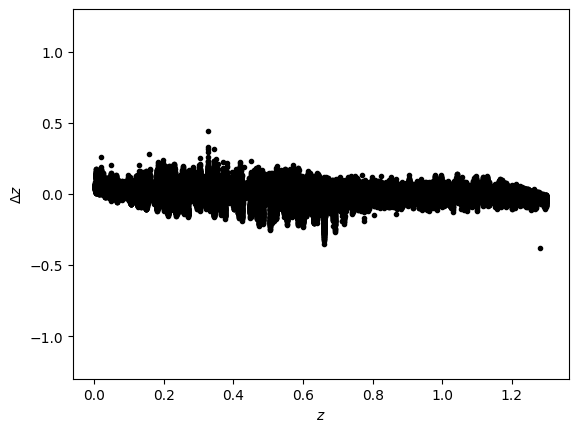

In [181]:
pnames = ['z', 't', '[Z/H]']

s = parvae(np.reshape(integrals[:80000], (80000,5)))
p = params[:80000]

res = s - p

print(s[0], p[0])
axs = (0, 0)


plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.plot(plx, ply, 'k.')
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()


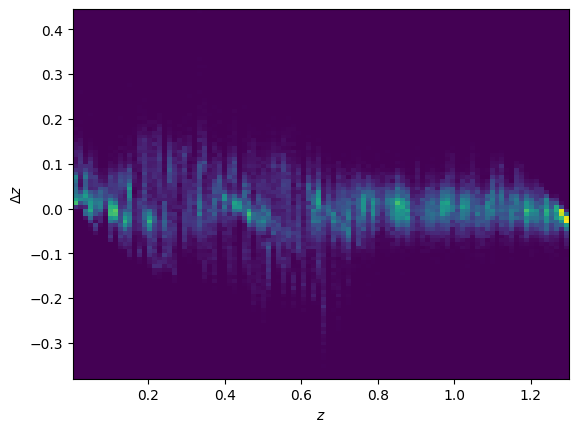

In [182]:
plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.hist2d(plx, ply, bins=100)
#plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

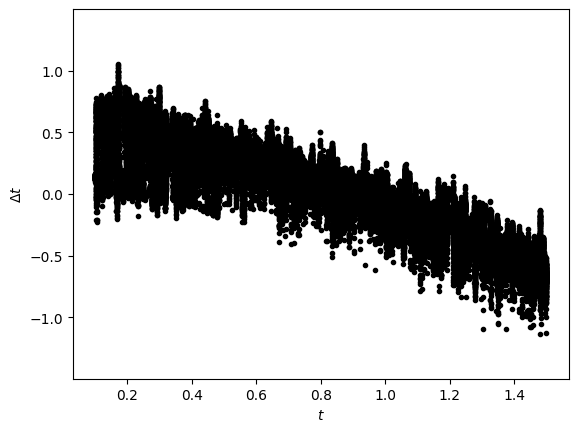

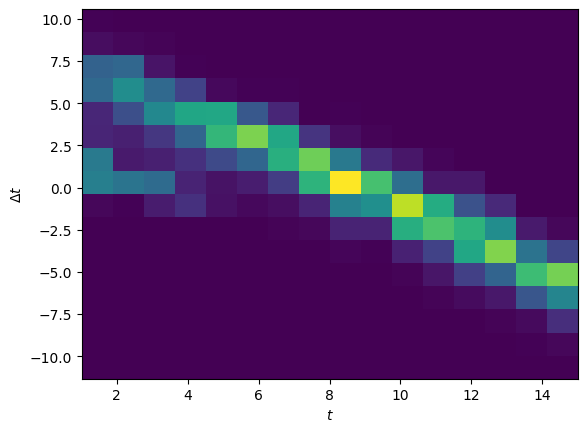

In [183]:
axs = (1, 1)


plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.plot(plx, ply, 'k.')
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

plx = p[:, axs[0]] * 10
ply = res[:, axs[1]] * 10.0
plt.hist2d(plx, ply, bins=16)
#plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

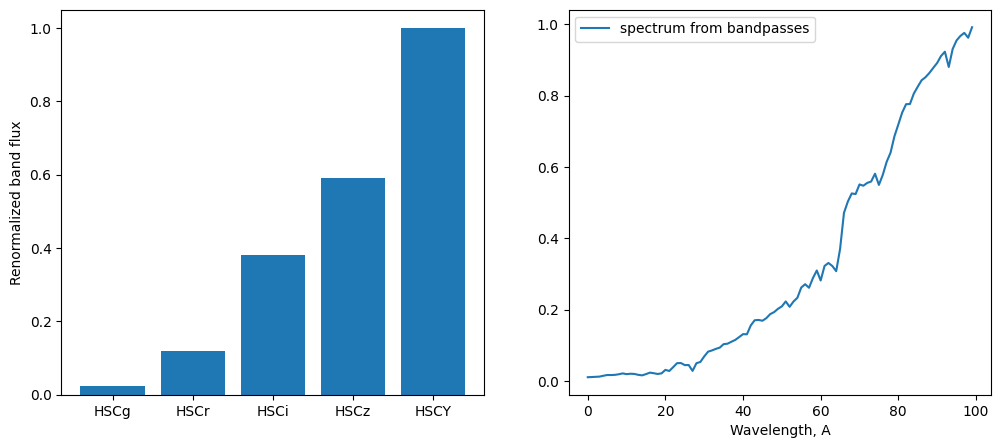

tf.Tensor([[ 1.0474635   0.9367635  -0.08757892]], shape=(1, 3), dtype=float32)


In [184]:
mags = np.array([24.369846, 22.666399, 21.405907, 20.927715, 20.358585])

bandfl = 10**(-0.4*mags)

bandfl /= np.max(bandfl)


fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
#axs[1].plot(wllr, spectra[ii], label="true spectrum")
s = bpvae(np.reshape(bandfl, (1,5)))
s = np.reshape(s[0].numpy(),(100,))
axs[1].plot(s, label="spectrum from bandpasses")
axs[1].set_xlabel('Wavelength, A')
axs[0].bar(filer_names, bandfl)
axs[0].set_ylabel('Renormalized band flux')
#fig.suptitle('z = %.2f' % (params[ii, 0]))
plt.legend()
plt.show()

s = parvae(np.reshape(bandfl, (1,5)))
print(s)

In [185]:
from astropy.table import Table

t_hsc = Table.read('http://gal-03.voxastro.org/~kirg/tmp/DESI_DR1_HSCSSP_clean.fits')

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_180']
Received: inputs=Tensor(shape=(111040, 5))
  warnings.warn(msg)


tf.Tensor([ 0.06323313  0.6550147  -0.5349745 ], shape=(3,), dtype=float32) 0.9265725982810769


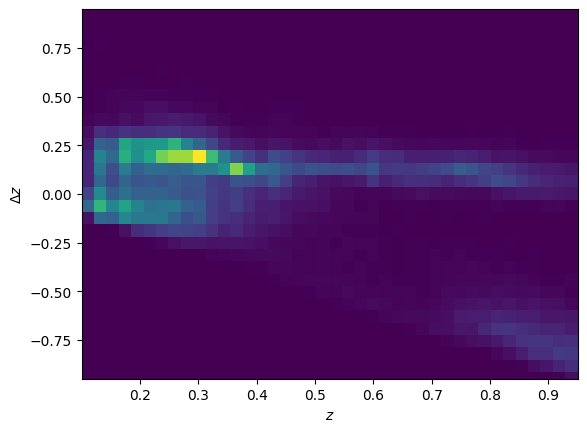

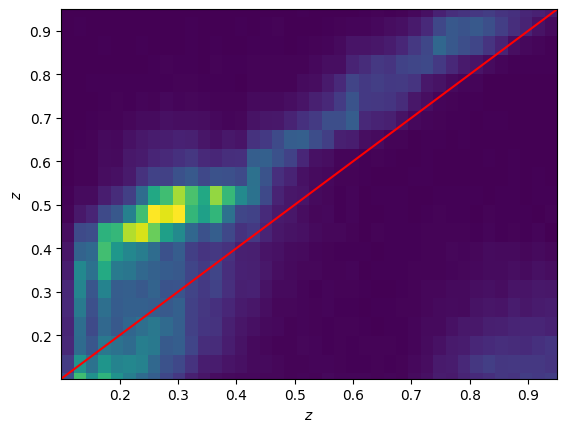

In [186]:
hsc_int = []
hsz_z = []
t_hsc = t_hsc[((t_hsc['z'] > 0.1) & (t_hsc['z'] < 0.95) & (t_hsc['zwarn'] == 0))]

for r in t_hsc:
    mags = mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
    bandfl = 10**(-0.4*mags)
    bandfl /= np.max(bandfl)
    hsc_int.append(bandfl)
    hsz_z.append(r['z'])

n = len(hsc_int)
pnames = ['z', 't', '[Z/H]']

s = parvae(np.reshape(hsc_int[:n], (n,5)))
p = hsz_z[:n]

res = s[:, 0] - p

print(s[0], p[0])
axs = (0, 0)


plx = p[:]
ply = res[:]
plt.hist2d(plx, ply, bins=40)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()


plx = p[:]
ply = res[:]
plt.hist2d(p[:], s[:, 0], bins=40)
plt.plot([0, 1], [0, 1], color='red')
plt.ylim(np.min(p[:]), np.max(p[:]))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$ ' + pnames[axs[1]] + '$')
plt.show()

t_hsc['z_photo'] = s[:, 0]


In [1]:
plx = p[:]
ply = res[:]
plt.plot(plx, ply, marker='.', color='black', linestyle=None, alpha=0.05)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()


NameError: name 'p' is not defined

In [188]:
t_hsc[((t_hsc['z'] < 0.5) & (t_hsc['z'] > 0.25) & (t_hsc['z_photo'] <0.15))]

object_id,ra,dec,g_kronflux_mag,r_kronflux_mag,i_kronflux_mag,z_kronflux_mag,y_kronflux_mag,z,mean_fiber_ra,targetid,tileid,zwarn,z_photo
,,,,,,,,,deg,,,,
int64,float64,float64,float32,float32,float32,float32,float32,float64,float64,int64,int32,int64,float32
37476063558783314,31.536867404161868,-4.4961581895148015,21.19661,20.502176,20.20959,20.006283,20.012117,0.2927052966822492,31.53686570647807,39627676595526816,80632,0,0.12452791
39622426220320746,37.33796399933065,-2.463966863866413,19.541656,18.799736,18.475794,18.299835,18.098633,0.2526827461386599,37.33795266271289,39627724955847381,25364,0,0.13543542
36425196730601026,34.33050609719254,-6.229742855592862,19.478928,18.790752,18.4857,18.337776,18.20496,0.2539396790273453,34.33049846155558,39627634522460476,23811,0,0.12837166
37476338436670972,31.282723359215623,-4.520741514425911,21.075768,20.393723,20.286613,20.038818,20.156761,0.3827903353493054,31.28272907849151,39627676591332412,80632,0,0.07687786
39627232288721620,38.3440453940428,-2.672869814635707,20.742146,19.917343,19.740114,19.479603,19.471725,0.3920819366455771,38.34417775067249,39627718932827291,25364,0,0.14390348
39604988653096927,31.152135904424657,-1.6820065980979675,20.171474,19.461582,19.162922,18.893951,18.873352,0.301312737785688,31.15210799040511,39627742970385432,20670,0,0.14628747
37471502303519848,30.270636263105708,-5.569225063928731,20.119045,19.391926,19.184473,18.833254,18.88813,0.3332118844781043,30.27061898382334,39627652490860033,22262,0,0.1461866
42806603304424260,31.466869090038475,1.6710428844691931,20.176697,19.591032,19.33191,19.241676,19.166073,0.2737458345914806,31.46687832922396,39627827531751576,20669,0,0.07128108


In [189]:
def corner_plot(r, max_params):
    axs = tuple(range(min(max_params, r[0].shape[1])))  # Ensure indices do not exceed max dimensions
    fig, axes = plt.subplots(len(axs), len(axs), figsize=(10, 10))

    for i, ax_i in enumerate(axs):
        for j, ax_j in enumerate(axs):
            ax = axes[i, j]

            if i == j:
                # Diagonal: 1D histogram
                ax.hist(r[0][:, ax_i], bins=100, color='steelblue', alpha=0.7)
            elif i > j:
                # Lower triangle: 2D histogram
                ax.hist2d(r[0][:, ax_j], r[0][:, ax_i], bins=100, cmap='Blues')
            else:
                # Upper triangle: empty space
                ax.set_visible(False)

            # Remove ticks for clarity
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()


    object_id            ra               dec         g_kronflux_mag r_kronflux_mag i_kronflux_mag z_kronflux_mag y_kronflux_mag         z            mean_fiber_ra        targetid     tileid zwarn  z_photo  
                                                                                                                                                           deg                                                 
----------------- ---------------- ------------------ -------------- -------------- -------------- -------------- -------------- ------------------ ----------------- ----------------- ------ ----- ----------
42811684250738155 32.0203856097501 1.5546428674397366      23.429956       21.77841       20.28644      19.866886      19.552792 0.7247619141927115 32.02038863666951 39627821504529172   6400     0 0.85891974
[ 1.23984775  0.74235057 -0.4957688 ]


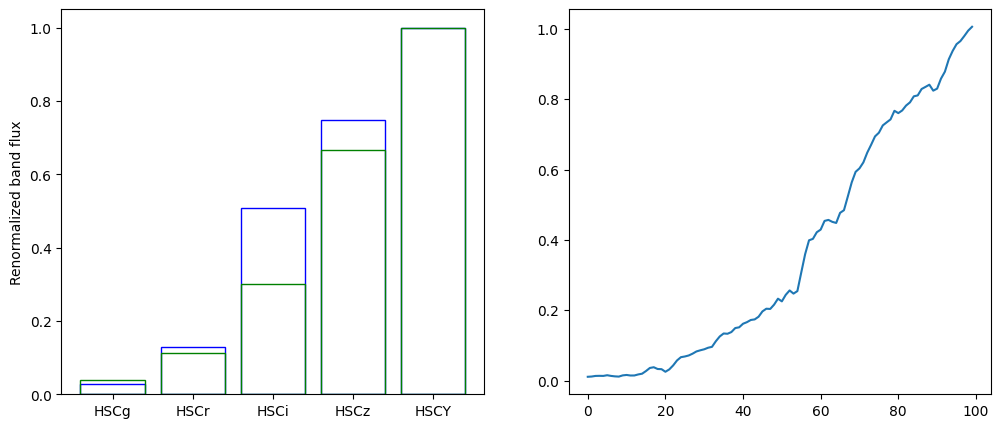

(<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[-1.7011493e-02, -4.5169145e-03,  2.4681456e-02,  4.8764572e-03,
         2.2161275e-02, -1.2088395e+00, -3.0989833e-02, -3.3127815e-03,
         1.6918615e-02, -5.7911873e-04,  2.5697705e-01, -5.1473975e-03,
        -9.5479637e-03, -1.5453328e+00, -2.4358876e-02, -6.6559017e-04]],
      dtype=float32)>, <tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[-3.4586042e-03, -1.4032083e-02, -1.5981514e-03, -2.7005309e-02,
        -8.7644849e-03, -3.0845053e+00, -2.0197302e-02, -2.0184699e-02,
         1.8961411e-03,  2.1126393e-02, -6.9592385e+00, -7.9589989e-03,
        -3.5179175e-02, -5.3070397e+00,  7.7524558e-03, -2.5748666e-03]],
      dtype=float32)>, <tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[-1.7749946 , -0.24747059, -0.2352348 ,  0.35246456, -0.11992155,
        -1.1083436 , -0.31559333,  0.806928  ,  0.42556792, -1.5113144 ,
         0.20965509, -1.7657912 ,  0.09513853, -1.6357789 , -0.06325805,
       

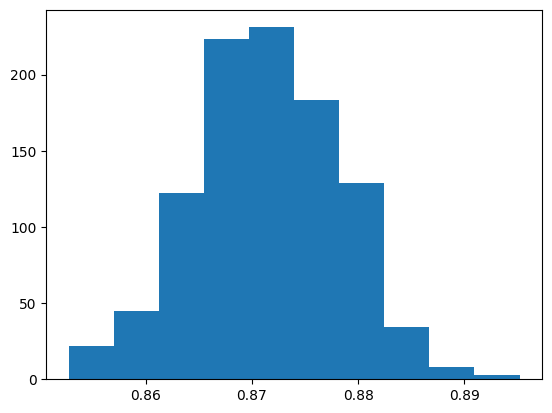

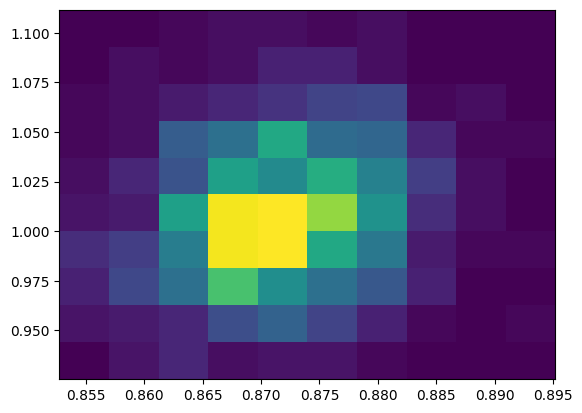

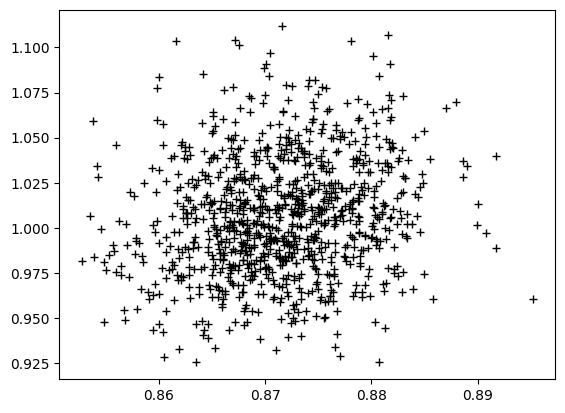

In [190]:
r = t_hsc[t_hsc['targetid'] == 39627821504529172][0]

ii = 50500

print(r)

mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
bandfl = 10**(-0.4*mags)

bandfl /= np.max(bandfl)

print(params[ii])

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
#axs[1].plot(wllr, spectra[ii], label="true spectrum")
#s = bpvae(np.reshape(bandfl, (1,5)))
#s = np.reshape(s[0].numpy(),(100,))
#axs[1].plot(wllr, s, label="spectrum from bandpasses")
#axs[1].set_xlabel('Wavelength, A')
axs[0].bar(filer_names, bandfl, fill=False, edgecolor='blue')
axs[0].bar(filer_names, integrals[ii], fill=False, edgecolor='green')
axs[0].set_ylabel('Renormalized band flux')
#fig.suptitle('z = %.2f' % (params[ii, 0]))

s = bpvae(np.reshape(bandfl, (1,5)))
s = np.reshape(s[0].numpy(),(100,))
axs[1].plot(s)

#plt.legend()
plt.show()

p_ls = parvae.apply(np.reshape(bandfl, (1,5)))


p = parvae(np.reshape(bandfl, (1,5)))

print(p_ls)

param_evals = []

nsmpl = 1000
for i in range(nsmpl):
    p_ls = parvae(np.reshape(bandfl, (1,5)))
    param_evals.append(p_ls[0].numpy())

param_evals = np.array(param_evals)
plt.hist(param_evals[:, 0])
plt.show()


plt.hist2d(param_evals[:, 0], param_evals[:, 1])
plt.show()

plt.plot(param_evals[:, 0], param_evals[:, 1], 'k+')
plt.show()

In [191]:
#r = bpvae.apply(np.reshape(integrals[:80000],(80000,5,1)))
#corner_plot(r, max_params=16)


In [192]:
t_hsc[((t_hsc['z'] < 0.99) & (t_hsc['z'] > 0.8) & (t_hsc['z_photo'] < 0.4))]

object_id,ra,dec,g_kronflux_mag,r_kronflux_mag,i_kronflux_mag,z_kronflux_mag,y_kronflux_mag,z,mean_fiber_ra,targetid,tileid,zwarn,z_photo
,,,,,,,,,deg,,,,
int64,float64,float64,float32,float32,float32,float32,float32,float64,float64,int64,int32,int64,float32
37480573274442668,32.8362869577959,-5.593018440395056,23.42605,23.392971,22.989925,22.933048,22.289661,0.9265725982810769,32.83632487035203,39627652532804446,11067,0,0.06323313
37481281944046281,32.03682550785276,-4.70071465302428,23.18282,22.980305,22.293991,22.110775,21.826351,0.917706278198227,32.03681963290541,39627670580894403,1664,0,0.3044811
39622447695136857,37.36221933406962,-1.5309441170693912,23.48132,23.113636,22.395777,22.220203,22.129353,0.8771188558909652,37.36222529082306,39627749115039190,3231,0,0.18011536
36421082151928961,32.5380971235688,-5.979053016109781,22.84253,22.486893,21.75785,21.523932,21.468874,0.9211800611724485,32.53808973392552,39627640499344861,6397,0,0.2239035
37480843857379106,32.543583346602,-5.8595107080615145,23.483017,23.428127,22.721004,22.491993,22.173056,0.9010986954370324,32.54360428732895,39627646513977212,1664,0,0.23323272
37472472966125033,29.075111087799115,-5.2206183788186875,22.97585,22.509228,22.06874,21.706648,21.856728,0.8236219919945724,29.07507822329063,39627658484522993,7442,0,0.15804741
37489932008188197,35.14179360115161,-4.952802710543259,23.366285,23.140785,22.532106,22.102688,22.443027,0.8457735767287892,35.14178400833873,39627664612394387,3239,0,0.24294369
40664484070576104,30.17856821671131,-1.1563514767293908,23.52974,23.147764,22.706612,22.379253,22.82518,0.8116538475000631,30.17855409720278,39627755033204569,1670,0,0.12533368


In [193]:
photoz_good = t_hsc[np.abs(t_hsc['z'] - t_hsc['z_photo']) < 0.15*(1 + t_hsc['z'])]
print(len(photoz_good), len(t_hsc), len(photoz_good)/len(t_hsc))

74394 111040 0.6699747838616714


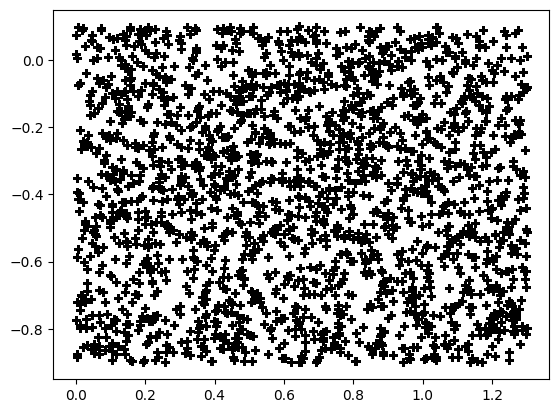

In [194]:
plt.plot(params[:, 0], params[:, 2], 'k+')
plt.show()